In [1]:
# %pip install tqdm
# %pip install pandas
# %pip install sklearn
# %pip install pillow
# %pip install seaborn
from tensorflow import keras
import tensorflow
import pandas as pd
import numpy as np
import functools
from time import time
import matplotlib.pyplot as plt
import math
from tensorflow.keras.preprocessing import image as imgproc
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D, Flatten, AveragePooling2D, LSTM, ConvLSTM2D
from tensorflow.keras.layers import TimeDistributed, Bidirectional, GRU, Dense, Dropout, Conv3D, MaxPooling3D, GlobalMaxPool3D
from tensorflow.keras.utils import Sequence, OrderedEnqueuer
import tensorflow as tf
from glob import glob
from tqdm import tqdm
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import seaborn as sns
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import tempfile
from sklearn.preprocessing import MinMaxScaler
import os
import random
from datetime import datetime
%load_ext tensorboard
%matplotlib inline
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version:", tensorflow.__version__)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
# Attempt to make runs more reproducible
seed_value=20212042
print("Using seed value: %d" % seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value) # tensorflow 2.x

Num GPUs Available: 1
Tensorflow version: 2.4.0
Using seed value: 20212042


In [2]:
# set up paths
base_dir = "/workspace/C684_Assignment/"
processing_dir = os.path.join(base_dir, "processing")
frames_dir = os.path.join(processing_dir, "att_maps")
train_dir = os.path.join(base_dir, "training")
train_frame_dir = os.path.join(train_dir, "train_frames")
chkp_dir = os.path.join(train_dir, "chkp")
if not os.path.exists(chkp_dir):
    os.makedirs(chkp_dir)
logs_dir = os.path.join(train_dir, "logs")
if not os.path.exists(logs_dir):
    os.makedirs(logs_dir)
    
# some global params
SIZE = (70, 70)
USE_ATT_MAPS = True
USE_AMNET_PRED = True
ATT_MAPS = [ 0, 1, 2 ] # full list - [ 0, 1, 2 ]
RGB = True
FRAME_INDEXES = [0, 48, 96, 144] # full list - [0, 24, 48, 72, 96, 120, 144]
BATCH_SIZE=32
TRAINING_ITERATIONS=1
EPOCHS=30
MULTIPROCESSING=True
WORKERS=8
SPEARMAN_THRESHOLD = 0.43
CHANNELS = len(ATT_MAPS) * (3 if RGB else 1)
NBFRAME = len(FRAME_INDEXES)

count    224000.000000
mean          0.600106
std           0.160918
min           0.000000
25%           0.487308
50%           0.628983
75%           0.726435
max           1.000000
Name: Y_pred, dtype: float64

AMNet Overall: short-term score=0.4183|mse=0.0194, long-term score=0.2143|mse=0.0232
AMNet Train: short-term score=0.4175|mse=0.0194, long-term score=0.2196|mse=0.0231
AMNet Test: short-term score=0.4214|mse=0.0195, long-term score=0.1867|mse=0.0235
Train size: 5100. Test size: 900


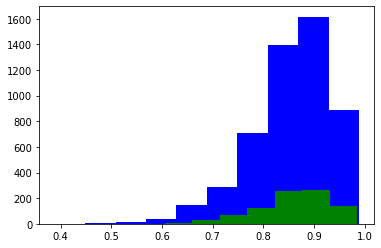

In [3]:
# load data
amnet_preds = pd.read_csv(os.path.join(processing_dir, "all_amnet_pred.csv")).set_index("video")
amnet_preds["Y_pred"] = MinMaxScaler().fit_transform(amnet_preds["Y_pred"].values.reshape(-1, 1))
display(amnet_preds["Y_pred"].describe())
dev_videos = pd.read_csv(os.path.join(processing_dir, "amnet_devset_preds.csv"))
dev_videos_train = dev_videos[dev_videos["test"]==False]
dev_videos_test = dev_videos[dev_videos["test"]==True]

# calculate AMNet scores
def calc_spearman(a1, a2):
    Res = pd.DataFrame()
    Res["Y_true"] = a1
    Res["Y_pred"] = a2
    return Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1).iloc[1][0]

amnet_short_score = calc_spearman(dev_videos["short-term_memorability"], dev_videos["Y_pred"])
amnet_short_mse = mean_squared_error(dev_videos["short-term_memorability"], dev_videos["Y_pred"])
amnet_long_score = calc_spearman(dev_videos["long-term_memorability"], dev_videos["Y_pred"])
amnet_long_mse = mean_squared_error(dev_videos["long-term_memorability"], dev_videos["Y_pred"])
print("AMNet Overall: short-term score=%.04f|mse=%.04f, long-term score=%.04f|mse=%.04f"
      % (amnet_short_score, amnet_short_mse, amnet_long_score, amnet_long_mse))
amnet_short_score = calc_spearman(dev_videos_train["short-term_memorability"], dev_videos_train["Y_pred"])
amnet_short_mse = mean_squared_error(dev_videos_train["short-term_memorability"], dev_videos_train["Y_pred"])
amnet_long_score = calc_spearman(dev_videos_train["long-term_memorability"], dev_videos_train["Y_pred"])
amnet_long_mse = mean_squared_error(dev_videos_train["long-term_memorability"], dev_videos_train["Y_pred"])
print("AMNet Train: short-term score=%.04f|mse=%.04f, long-term score=%.04f|mse=%.04f"
      % (amnet_short_score, amnet_short_mse, amnet_long_score, amnet_long_mse))
amnet_short_score = calc_spearman(dev_videos_test["short-term_memorability"], dev_videos_test["Y_pred"])
amnet_short_mse = mean_squared_error(dev_videos_test["short-term_memorability"], dev_videos_test["Y_pred"])
amnet_long_score = calc_spearman(dev_videos_test["long-term_memorability"], dev_videos_test["Y_pred"])
amnet_long_mse = mean_squared_error(dev_videos_test["long-term_memorability"], dev_videos_test["Y_pred"])
print("AMNet Test: short-term score=%.04f|mse=%.04f, long-term score=%.04f|mse=%.04f"
      % (amnet_short_score, amnet_short_mse, amnet_long_score, amnet_long_mse))

# train/test y_true histogram
X_train = dev_videos_train["video"]
y_train = dev_videos_train["short-term_memorability"]
X_test = dev_videos_test["video"]
y_test = dev_videos_test["short-term_memorability"]
train_size = X_train.shape[0]
test_size = X_test.shape[0]
print("Train size: %d. Test size: %d" % (train_size, test_size))
plt.hist(y_train, color='blue')
plt.hist(y_test, color='green')
plt.show()

In [4]:
class TrainTestSequence(Sequence):
    def __init__(self, X_set, y_set, do_shuffle):
        self.x, self.y = X_set, y_set
        self.do_shuffle = do_shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return len(self.x) // BATCH_SIZE
    
    def _load_images(self, batch):
        images = np.zeros((len(batch), NBFRAME, SIZE[0], SIZE[1], CHANNELS))
        for video_index, video in enumerate(batch):
            for sequence_index, frame_index in enumerate(FRAME_INDEXES):
                filename = "%s_%d_att.jpg" % (video, frame_index)
                pilimg = []
                for img_index in ATT_MAPS:
                    dirname = "%s-%d" % (train_frame_dir, img_index)
                    img = imgproc.load_img(os.path.join(dirname, filename))
                    if not RGB:
                        img = img.convert('L')
                    img = img.resize(SIZE)
                    img = imgproc.img_to_array(img)
                    pilimg.append(img)
                images[video_index][sequence_index] = np.concatenate(pilimg, axis=2) / 255.
        return images
    
    def _load_amnet_preds(self, batch):
        batch_amnet_preds = np.zeros((len(batch), NBFRAME))
        for video_index, video in enumerate(batch):
            for sequence_index, frame_index in enumerate(FRAME_INDEXES):
                frame_id = "%s_%d" % (video, frame_index)
                batch_amnet_preds[video_index][sequence_index] = amnet_preds.loc[frame_id, "Y_pred"]
        return batch_amnet_preds
    
    def on_epoch_end(self):
        if self.do_shuffle:
            self.x, self.y = shuffle(self.x, self.y)
            
    def __getitem__(self, idx):
        batch_x = self.x[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_y = self.y[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_x_features = []
        if USE_ATT_MAPS:
            batch_x_features.append(self._load_images(batch_x))
        if USE_AMNET_PRED:
            batch_x_features.append(self._load_amnet_preds(batch_x))
        return batch_x_features, np.array(batch_y)

def make_generator(X_set, y_set, shuffle, worker_count):
    seq = TrainTestSequence(X_set, y_set, shuffle)
    enq = OrderedEnqueuer(seq, use_multiprocessing=MULTIPROCESSING, shuffle=shuffle)
    enq.start(workers=worker_count, max_queue_size=worker_count*20)
    return enq

class SpearmanCalcCallback(keras.callbacks.Callback):
    def __init__(self, X_test, y_test, batch_size, worker_count):
        batch_remainder = y_test.shape[0] % batch_size
        self.steps = y_test.shape[0] // batch_size
        self.y_test = y_test[:-batch_remainder]
        self.X_test = X_test[:-batch_remainder]
        self.worker_count = worker_count
        self.generator = make_generator(self.X_test, self.y_test, False, self.worker_count)
        
    def on_epoch_end(self, zero_based_epoch, logs=None):
        epoch = zero_based_epoch + 1
        y_pred = self.model.predict(self.generator.get(), steps=self.steps)
        
        # reset generator before next epoch
        self.generator.stop()
        self.generator.start(workers=self.worker_count)
        
        Res = pd.DataFrame()
        Res["Y_true"] = self.y_test
        Res["Y_pred"] = y_pred
        score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1).iloc[1][0]
        print()
        print("*** Epoch %d: Spearman's correlation = %.4f" % (epoch, score_mat))
        mse = mean_squared_error(Res["Y_true"], Res["Y_pred"])
        print("*** Epoch %d: MSE = %.4f" % (epoch, mse))
        plt.hist(y_pred)
        plt.show()
            
        if score_mat > SPEARMAN_THRESHOLD:
            model_file = os.path.join(chkp_dir, "weights-%.04f-%s-%d.hdf5" % (score_mat, self.run_id, epoch))
            print("*** Saving model to file %s" % model_file)
            model.save(model_file)
        print()

    def set_run(self, run_id, model):
        timestamp = datetime.now().strftime("%d_%m_%Y_%H_%M")
        self.run_id = "%s-%d" % (timestamp, run_id)
        self.model = model
        return self
    
    def evaluate_model(self, model):
        self.set_run(0, model)
        self.on_epoch_end(-1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 70, 70, 9 0                                            
__________________________________________________________________________________________________
conv_lst_m2d (ConvLSTM2D)       (None, 4, 70, 70, 20 20960       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 4, 35, 35, 20 0           conv_lst_m2d[0][0]               
__________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)     (None, 4, 35, 35, 10 10840       max_pooling3d[0][0]              
______________________________________________________________________________________________

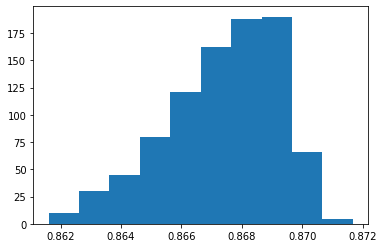


Epoch 2/30
159/159 [==============================] - 90s 567ms/step - loss: 0.0061

*** Epoch 1: Spearman's correlation = 0.4112

*** Epoch 2: Spearman's correlation = 0.4244
*** Epoch 2: MSE = 0.0057


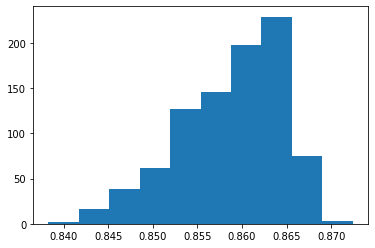


Epoch 3/30
159/159 [==============================] - 75s 470ms/step - loss: 0.0061


*** Epoch 3: Spearman's correlation = 0.4363
*** Epoch 3: MSE = 0.0056


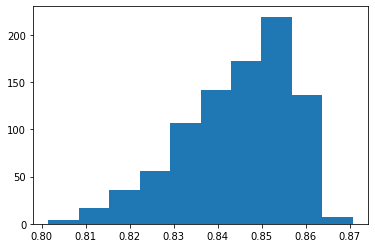

*** Saving model to file /workspace/C684_Assignment/training/chkp/weights-0.4363-20_04_2021_22_07-0-3.hdf5

Epoch 4/30
 22/159 [===>..........................] - ETA: 1:05 - loss: 0.0061

Process Keras_worker_ForkPoolWorker-82:
Process Keras_worker_ForkPoolWorker-84:
Process Keras_worker_ForkPoolWorker-83:
Process Keras_worker_ForkPoolWorker-68:
Process Keras_worker_ForkPoolWorker-66:
Process Keras_worker_ForkPoolWorker-81:
Process Keras_worker_ForkPoolWorker-85:
Process Keras_worker_ForkPoolWorker-87:
Process Keras_worker_ForkPoolWorker-65:
Process Keras_worker_ForkPoolWorker-86:
Process Keras_worker_ForkPoolWorker-71:
Process Keras_worker_ForkPoolWorker-67:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-69:
Process Keras_worker_ForkPoolWorker-70:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.r

  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/data_utils.py", line 567, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/utils.py", line 113, in load_img
    with open(path, 'rb') as f:
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-4-d4a43571e59c>", line 18, in _load_images
    img = imgproc.load_img(os.path.join(dirname, filename))
  File "/usr/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
Keyboard

KeyboardInterrupt: 

In [5]:
# define model
def functional_model(shape=(NBFRAME,) + SIZE + (CHANNELS,)):
    frame_inputs = keras.Input(shape=shape)
    f = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding='same',
                   return_sequences=True)(frame_inputs)
    f = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(f)
    f = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding='same',
                   return_sequences=True)(f)
    f = MaxPooling3D(pool_size=(1, 3, 3), padding='same')(f)
    f = ConvLSTM2D(filters=5, kernel_size=(3, 3), padding='same',
                   return_sequences=True)(f)
    f = MaxPooling3D(pool_size=(1, 2, 2), padding='same')(f)
    f = TimeDistributed(Flatten())(f)
    f = TimeDistributed(Dense(512))(f)
    f = TimeDistributed(Dropout(0.5))(f)
    f = TimeDistributed(Dense(64))(f)
    f = Flatten()(f)
    f = Dense(128)(f)
    pred_inputs = keras.Input(shape=(NBFRAME,1,))
    p = keras.layers.LSTM(32, return_sequences=True)(pred_inputs)
    p = keras.layers.LSTM(32, return_sequences=True)(p)
    p = Flatten()(p)
    p = Dense(128)(p)
    
    inputs = None
    if USE_ATT_MAPS and USE_AMNET_PRED:
        f = keras.layers.Average()([f, p])
        inputs = [frame_inputs, pred_inputs]
    elif USE_ATT_MAPS:
        inputs = [frame_inputs]
    elif USE_AMNET_PRED:
        f = p
        inputs = [pred_inputs]
    else:
        raise Exception("USE_ATT_MAPS and/or USE_AMNET_PRED needs to be True")

    f = keras.layers.BatchNormalization()(f)
    f = Dense(64)(f)
    f = Dense(1, activation='sigmoid')(f)
    model = keras.Model(inputs=inputs, outputs=f)
    print(model.summary())
    return model

# train model
train_generator = make_generator(X_train, y_train, True, WORKERS).get()
validation_callback = SpearmanCalcCallback(X_test, y_test, BATCH_SIZE, WORKERS)
for attempt in range(TRAINING_ITERATIONS):
    model = functional_model()
    model.compile(
        optimizer='adam',
        loss='mse'
    )
    callbacks = [
        keras.callbacks.TensorBoard(log_dir=os.path.join(logs_dir, "{}".format(time()))),
        validation_callback.set_run(attempt, model)
    ]
    model.fit(train_generator,
              epochs=EPOCHS,
              steps_per_epoch=train_size//BATCH_SIZE,
              callbacks=callbacks)